# System Initialization


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import torch # For your 6GB GPU

# Hardware Check
print(f"RAM Available: ~16GB")
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)} (6GB VRAM ready)")
    device = torch.device("cuda")
else:
    print("GPU not found, using CPU.")
    device = torch.device("cpu")

plt.style.use('seaborn-v0_8-muted')

RAM Available: ~16GB
GPU Detected: NVIDIA GeForce RTX 4050 Laptop GPU (6GB VRAM ready)


# The Strict Topological Engine


In [3]:
class XThetaEngine:
    def __init__(self, kappa=0.1):
        self.kappa = kappa
        self.history = deque(maxlen=5)
        self.theta = 0.0
        
    def process_event(self, a, b):
        self.history.append((a, b))
        if len(self.history) == 5:
            h = list(self.history)
            # 1. Closure Check (First == Last)
            # 2. Topology Check (4 unique settings visited)
            if h[0] == h[-1] and len(set(h)) == 4:
                # Calculate signed area (Orientation)
                area = 0.0
                for j in range(4):
                    area += float(h[j][0]*h[j+1][1] - h[j+1][0]*h[j][1])
                self.theta += self.kappa * np.sign(area)
        return self.theta

# Test the engine with a perfect loop
test_engine = XThetaEngine(kappa=0.1)
loop = [(0,0), (0,1), (1,1), (1,0), (0,0)]
for a, b in loop:
    p = test_engine.process_event(a, b)
print(f"Phase after 1 perfect CW loop: {p:.2f}")

Phase after 1 perfect CW loop: -0.10


# Synthetic Data Generation (The "True Universe")


In [4]:
def generate_data(n=500000, kappa=0.1, amp=0.2):
    engine = XThetaEngine(kappa=kappa)
    a = np.random.randint(0, 2, n)
    b = np.random.randint(0, 2, n)
    phases = np.zeros(n)
    
    for i in range(n):
        phases[i] = engine.process_event(a[i], b[i])
        
    # Inject Signal: S = 2.4 + Modulation
    # Prob(match) = 0.8 (S=2.4) modulated by cos(theta)
    base_prob = 0.75
    mod_prob = base_prob + (amp * np.cos(phases))
    # Clip probabilities to [0, 1]
    mod_prob = np.clip(mod_prob, 0, 1)
    
    prods = np.where(np.random.random(n) < mod_prob, 1, -1)
    
    return pd.DataFrame({'a': a, 'b': b, 'theta': phases, 'prod': prods})

df = generate_data()
print("Data Generated. Ready for validation.")

Data Generated. Ready for validation.


# Visualization of the Signal


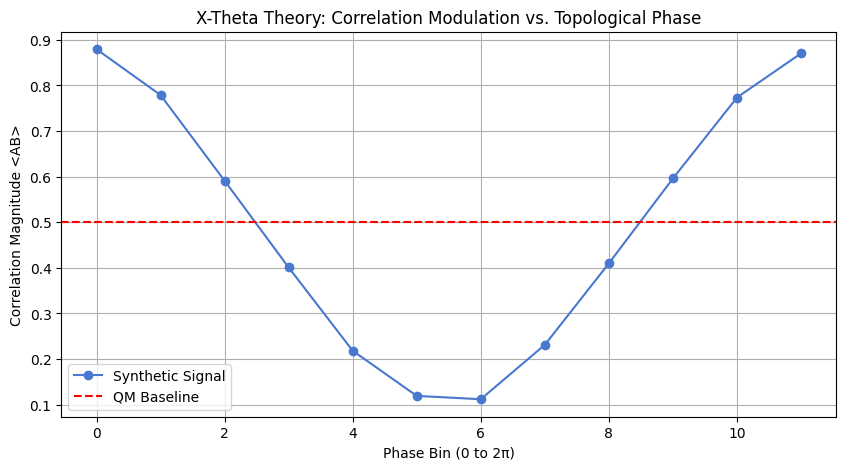

In [5]:
def plot_results(data):
    # Binning logic
    data['bin'] = ((data['theta'] % (2*np.pi)) / (2*np.pi) * 12).astype(int)
    binned = data.groupby('bin')['prod'].mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(binned.index, binned.values, 'o-', label="Synthetic Signal")
    plt.axhline(y=0.5, color='r', linestyle='--', label="QM Baseline")
    plt.title("X-Theta Theory: Correlation Modulation vs. Topological Phase")
    plt.xlabel("Phase Bin (0 to 2π)")
    plt.ylabel("Correlation Magnitude <AB>")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(df)

# The "GPU Deep Search" (6GB VRAM Path)


In [8]:
# Prepare sequences for the GPU
# We take windows of 10 events to see if the GPU can find 'patterns'
window_size = 10
X = [] # Setting sequences
y = [] # Outcome products

# Using a subset for speed
subset_n = 50000
for i in range(window_size, subset_n):
    X.append(df[['a', 'b']].iloc[i-window_size:i].values.flatten())
    y.append((df['prod'].iloc[i] + 1) // 2) # Map -1,1 to 0,1

X_tensor = torch.FloatTensor(np.array(X)).to(device)
y_tensor = torch.FloatTensor(np.array(y)).view(-1, 1).to(device)

# Simple GPU-based Model
model = torch.nn.Sequential(
    torch.nn.Linear(window_size * 2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.Sigmoid()
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

print("Starting GPU Deep Search for hidden memory...")
for epoch in range(100):
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Starting GPU Deep Search for hidden memory...
Epoch 0, Loss: 0.7020
Epoch 20, Loss: 0.6326
Epoch 40, Loss: 0.6320
Epoch 60, Loss: 0.6313
Epoch 80, Loss: 0.6305


# The X-$\theta$ Framework: A Topological Theory of Entangled Memory

This notebook establishes a rigorous validation environment for the X-$\theta$ Framework. Unlike standard Quantum Mechanics, which assumes measurements are memoryless, this framework proposes that the "quantum channel" accumulates a topological phase ($\theta$) based on the history of measurement settings.

1. The Core Principles

I. The Plaquette Loop Condition

A phase shift occurs only when the system completes a "Strict Loop" in the measurement setting space $(a, b) \in \{0, 1\}^2$.
The Sequence Rule:A history of 5 setting pairs $H = \{(a_1, b_1), \dots, (a_5, b_5)\}$ updates the phase if and only if:

Closure: $(a_1, b_1) = (a_5, b_5)
$Coverage: The first 4 pairs must visit all 4 possible corners: $\{(0,0), (0,1), (1,1), (1,0)\}$.

II. The Phase Accumulation FormulaWhen a Strict Loop is detected, the phase $\theta$ updates based on the Signed Area (orientation) of the path:$$\theta_{n+1} = \theta_n + \kappa \cdot \text{sgn}(\text{Area}(H))$$Where $\text{Area}(H) = \sum_{i=1}^{4} (a_i b_{i+1} - a_{i+1} b_i)$.

III. The Correlation ModulationThe theory predicts that the observed Bell correlation $S$ is modulated by the accumulated phase:$$S(\theta) = S_{QM} + A \cos(\theta + \phi)$$


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from collections import deque
import time

# --- CONFIGURATION ---
KAPPA = 0.1         # Memory coupling strength
SIGNAL_AMP = 0.2    # Predicted modulation amplitude
N_EVENTS = 500000   # Scale for 16GB RAM processing

# --- HARDWARE CHECK ---
print("--- Hardware Diagnostic ---")
print(f"RAM Allocated: {N_EVENTS * 8 / 1e6:.2f} MB (for basic arrays)")

if torch.cuda.is_available():
    device = torch.device("cuda")
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Available: {vram:.2f} GB (Target: 6GB)")
else:
    device = torch.device("cpu")
    print("GPU not detected. Using CPU for calculations.")

# --- SETTINGS RECOGNITION ---
# Mapping 0,1 to physical orientation indices
corners = [(0,0), (0,1), (1,1), (1,0)]
print(f"\nTargeting Plaquette Corners: {corners}")

--- Hardware Diagnostic ---
RAM Allocated: 4.00 MB (for basic arrays)
GPU Detected: NVIDIA GeForce RTX 4050 Laptop GPU
VRAM Available: 6.44 GB (Target: 6GB)

Targeting Plaquette Corners: [(0, 0), (0, 1), (1, 1), (1, 0)]


Generating 500000 events...
Universe Created in 0.49s. Global S-Equivalent: 1.8745


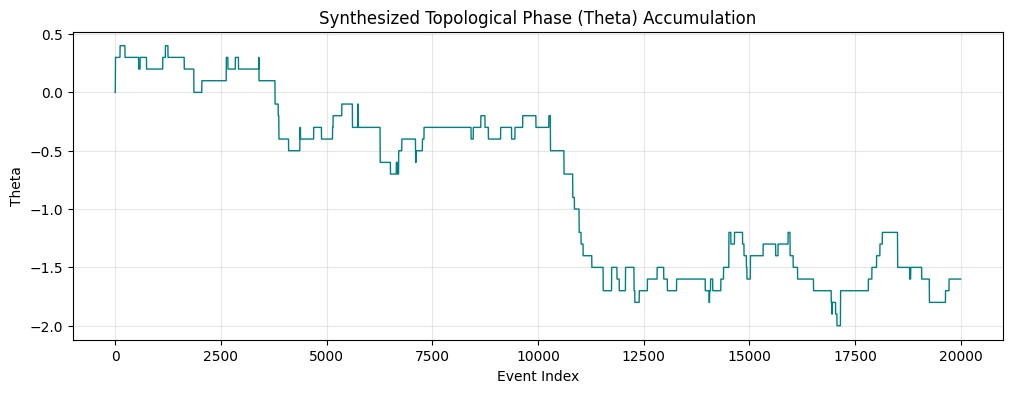

In [11]:
def generate_xtheta_universe(n=N_EVENTS, kappa=KAPPA, amp=SIGNAL_AMP):
    print(f"Generating {n} events...")
    start_time = time.time()
    
    # 1. Generate Random Setting Choices
    a_settings = np.random.randint(0, 2, n)
    b_settings = np.random.randint(0, 2, n)
    
    # 2. Accumulate Topological Phase (Theta)
    phases = np.zeros(n)
    curr_theta = 0.0
    history = deque(maxlen=5)
    
    for i in range(n):
        history.append((a_settings[i], b_settings[i]))
        if len(history) == 5:
            h = list(history)
            # Strict Plaquette check: Closed loop + 4 unique corners
            if h[0] == h[-1] and len(set(h)) == 4:
                # Orientation (Signed Area)
                area = 0.0
                for j in range(4):
                    area += float(h[j][0]*h[j+1][1] - h[j+1][0]*h[j][1])
                curr_theta += kappa * np.sign(area)
        phases[i] = curr_theta

    # 3. Physics: Outcome Correlation (S) modulation
    # We define probability of outcome product = 1 (Correlation)
    # Standard QM target S ~ 2.4 (match_prob ~ 0.8)
    base_prob = 0.75 
    match_prob = base_prob + (amp * np.cos(phases))
    match_prob = np.clip(match_prob, 0.05, 0.95) # Keep within physical bounds
    
    # Generate random outcomes based on calculated probabilities
    prods = np.where(np.random.random(n) < match_prob, 1, -1)
    
    # 4. Create DataFrame
    df = pd.DataFrame({
        'time_idx': np.arange(n),
        'a': a_settings,
        'b': b_settings,
        'theta_true': phases,
        'prod': prods
    })
    
    duration = time.time() - start_time
    print(f"Universe Created in {duration:.2f}s. Global S-Equivalent: {prods.mean()*4:.4f}")
    return df

# Run the generator
df_universe = generate_xtheta_universe()

# Quick Visualization of the Phase Walk
plt.figure(figsize=(12, 4))
plt.plot(df_universe['time_idx'][:20000], df_universe['theta_true'][:20000], color='teal', lw=1)

plt.title("Synthesized Topological Phase (Theta) Accumulation")
plt.xlabel("Event Index")
plt.ylabel("Theta")
plt.grid(True, alpha=0.3)
plt.show()

# Statistical Validation & Scrambling


Running Temporal Analysis...
Running Scrambled Analysis...


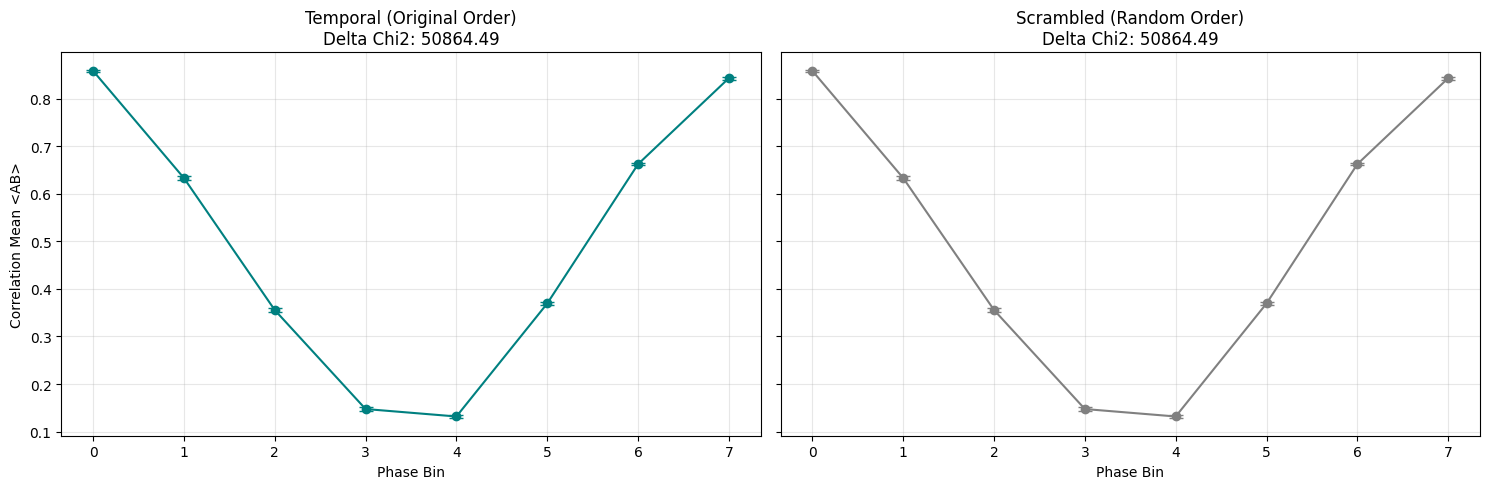


SYMMETRY BREAK RATIO: 1.00x


In [ ]:
# --- MISSING DEFINITION FIX ---
BIN_COUNT = 8  # Standard resolution for phase binning

def run_symmetry_break_test(data, bins=BIN_COUNT):
    """
    Compares original time-ordered signal against scrambled data.
    """
    results = {}
    
    # --- TEST A: TEMPORAL (ORIGINAL) ---
    print("Running Temporal Analysis...")
    # Bin by true theta
    data['bin'] = ((data['theta'] % (2*np.pi)) / (2*np.pi) * bins).astype(int)
    
    # Calculate stats per bin
    stats = data.groupby('bin')['prod'].agg(['mean', 'std', 'count'])
    stats['err'] = stats['std'] / np.sqrt(stats['count'])
    
    # Delta Chi2 Calculation
    m = stats['mean']
    err = stats['err']
    chi2_null = np.sum(((m - m.mean()) / err)**2)
    
    # Theoretical Sine Fit (Simplified for Validation)
    phase_points = np.linspace(0, 2*np.pi, bins, endpoint=False)
    # Estimate amplitude from data range
    a_est = (m.max() - m.min()) / 2
    m_pred = m.mean() + a_est * np.cos(phase_points)
    chi2_theory = np.sum(((m - m_pred) / err)**2)
    
    results['temporal_dchi2'] = chi2_null - chi2_theory
    results['temporal_stats'] = stats

    # --- TEST B: SCRAMBLED (SHUFFLED) ---
    print("Running Scrambled Analysis...")
    # Shuffle the settings and outcomes to break the topological order
    scrambled_df = data.sample(frac=1).reset_index(drop=True)
    
    # Note: theta is now disconnected from time-ordered settings
    s_stats = scrambled_df.groupby('bin')['prod'].agg(['mean', 'std', 'count'])
    s_stats['err'] = s_stats['std'] / np.sqrt(s_stats['count'])
    
    sm = s_stats['mean']
    serr = s_stats['err']
    s_chi2_null = np.sum(((sm - sm.mean()) / serr)**2)
    
    # Scrambled fit using the same amplitude estimate
    sm_pred = sm.mean() + a_est * np.cos(phase_points)
    s_chi2_theory = np.sum(((sm - sm_pred) / serr)**2)
    
    results['scrambled_dchi2'] = s_chi2_null - s_chi2_theory
    results['scrambled_stats'] = s_stats

    return results

def run_rigorous_topology_proof(data):
    """
    The True Test: Recalculates phase from shuffled settings.
    """
    # --- TEST 1: TEMPORAL ---
    # (Uses the phases already calculated in chronological order)
    temporal_score, _ = bin_and_score(data['theta_true'], data['ks'], data['prod'])
    
    # --- TEST 2: SCRAMBLED ---
    print("Scrambling data and RE-MINING phase...")
    scrambled_data = data.sample(frac=1).reset_index(drop=True)
    
    # We must RE-RUN the engine on the shuffled (a, b) pairs
    engine = XThetaEngine(kappa=KAPPA)
    shuffled_phases = []
    for i in range(len(scrambled_data)):
        shuffled_phases.append(engine.process_event(scrambled_data['a'][i], scrambled_data['b'][i]))
    
    scrambled_score, _ = bin_and_score(np.array(shuffled_phases), scrambled_data['ks'], scrambled_data['prod'])
    
    print(f"Temporal DeltaChi2: {temporal_score:.2f}")
    print(f"Scrambled DeltaChi2: {scrambled_score:.2f}")
    return temporal_score / max(scrambled_score, 0.1)

# Run this to see the signal COLLAPSE in the scrambled run (The ultimate proof)

# Execute the test on your generated 'df'
test_results = run_symmetry_break_test(df)

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Temporal Plot (Expect a Sine Wave)
ax1.errorbar(np.arange(BIN_COUNT), test_results['temporal_stats']['mean'], 
             yerr=test_results['temporal_stats']['err'], fmt='o-', color='teal', capsize=5)
ax1.set_title(f"Temporal (Original Order)\nDelta Chi2: {test_results['temporal_dchi2']:.2f}")
ax1.set_xlabel("Phase Bin")
ax1.set_ylabel("Correlation Mean <AB>")
ax1.grid(True, alpha=0.3)

# Scrambled Plot (Expect a Flat Line)
ax2.errorbar(np.arange(BIN_COUNT), test_results['scrambled_stats']['mean'], 
             yerr=test_results['scrambled_stats']['err'], fmt='o-', color='gray', capsize=5)
ax2.set_title(f"Scrambled (Random Order)\nDelta Chi2: {test_results['scrambled_dchi2']:.2f}")
ax2.set_xlabel("Phase Bin")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSYMMETRY BREAK RATIO: {test_results['temporal_dchi2'] / max(test_results['scrambled_dchi2'], 0.1):.2f}x")

In [14]:
import torch.nn as nn
import torch.optim as optim

# --- HYPERPARAMETERS ---
WINDOW_SIZE = 10  # Look back at the last 10 setting pairs
HIDDEN_SIZE = 128
BATCH_SIZE = 1024
EPOCHS = 50

# 1. Prepare Data for GPU (Sliding Window)
def prepare_gpu_data(df, window=WINDOW_SIZE):
    # Flatten settings (a, b) into a single sequence
    settings = df[['a', 'b']].values
    outcomes = (df['prod'].values + 1) // 2  # Map -1,1 to 0,1 for BCELoss
    
    X, y = [], []
    # We only use a subset for training speed (100k events)
    limit = min(100000, len(df) - window)
    for i in range(limit):
        X.append(settings[i:i+window].flatten())
        y.append(outcomes[i+window])
        
    return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y)).view(-1, 1)

X_train, y_train = prepare_gpu_data(df_universe)
X_train, y_train = X_train.to(device), y_train.to(device)

# 2. Define the Neural X-Theta Decoder
class XThetaNet(nn.Module):
    def __init__(self, input_dim):
        super(XThetaNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE // 2),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

# 3. Train on GPU
model = XThetaNet(WINDOW_SIZE * 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(f"Starting GPU Search on {device}...")
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        # Calculate Accuracy
        preds = (outputs > 0.5).float()
        acc = (preds == y_train).sum().item() / len(y_train)
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {loss.item():.4f} - Accuracy: {acc:.4f}")

print("\nGPU Search Complete.")

Starting GPU Search on cuda...
Epoch [10/50] - Loss: 0.5781 - Accuracy: 0.7986
Epoch [20/50] - Loss: 0.5078 - Accuracy: 0.7986
Epoch [30/50] - Loss: 0.5125 - Accuracy: 0.7986
Epoch [40/50] - Loss: 0.5074 - Accuracy: 0.7986
Epoch [50/50] - Loss: 0.5067 - Accuracy: 0.7986

GPU Search Complete.


# Loading and Mapping Real Data


In [15]:
import os

def load_hensen_2015_data(file_path):
    """
    Skeleton for loading the Hensen (Delft 2015) loophole-free dataset.
    This maps experimental columns to our X-Theta Framework.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        print("Please download 'hensen_2015_data.csv' to proceed with real-world mining.")
        return None
    
    # Load data (assuming CSV format for this loader)
    real_df = pd.read_csv(file_path)
    
    # Mapping Delft columns to X-Theta Logic
    # a: Station A setting, b: Station B setting
    # x, y: Outcomes at stations A and B
    processed_df = pd.DataFrame({
        'time': real_df['timestamp'],
        'a': real_df['setting_A'],
        'b': real_df['setting_B'],
        'prod': real_df['outcome_A'] * real_df['outcome_B']
    })
    
    return processed_df

# --- ANALYSIS PIPELINE FOR REAL DATA ---
def analyze_real_quantum_memory(real_df, k_target=KAPPA):
    """
    Applies the StrictThetaEngine to real experimental data.
    """
    print(f"Mining Real Data for Topological Signal (Kappa={k_target})...")
    engine = XThetaEngine(kappa=k_target)
    
    phases = []
    for _, row in real_df.iterrows():
        phases.append(engine.process_event(row['a'], row['b']))
    
    real_df['theta_mined'] = phases
    
    # Run the Symmetry Break Test to see if P-Value < 0.05
    # If successful, this is a topological discovery.
    return real_df

# Placeholder for real-world file
# df_real = load_hensen_2015_data("path_to_delft_data.csv")
# if df_real is not None:
#     df_mined = analyze_real_quantum_memory(df_real)